# Prepare Hardware and Package

In [0]:
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchfile
from torchbearer import Trial
import torch.optim as optim
import PIL.Image as Image
import cv2
import matplotlib.pyplot as plt


# Load and preprocess data

In [0]:
# import zipfile
# import os
# files = zipfile.ZipFile('Data.zip', 'r')
# files.extractall(os.getcwd())
# files.close()  

In [0]:
mean = [0.367035294117647,0.41083294117647057,0.5066129411764705]
transform = transforms.Compose([
                                transforms.Resize(size=(224,224)),
                                # transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, [1/255, 1/255, 1/255])
                                ])


In [0]:
train_path = '/content/drive/My Drive/Data/train'
test_path = '/content/drive/My Drive/Data/test'
val_path = '/content/drive/My Drive/Data/val'
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(train_data[0][0].size())
print(train_data)

torch.Size([3, 224, 224])
Dataset ImageFolder
    Number of datapoints: 3198
    Root location: /content/drive/My Drive/Data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.367035294117647, 0.41083294117647057, 0.5066129411764705], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098])
           )


In [0]:
batch_size = 64
train_loader = data.DataLoader(train_data, batch_size=batch_size)
val_loader = data.DataLoader(val_data, batch_size=batch_size)
test_loader = data.DataLoader(test_data, batch_size=batch_size)

# Implement VGG16

In [0]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, (3,3), stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, (3,3), stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, (3,3), stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, (3,3), stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, (3,3), stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, (3,3), stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, (3,3), stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, (3,3), stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
        self.fc1 = nn.Linear(512*7*7, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)


    def forward (self, x):
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5, self.training)

        return self.fc3(x)

    def load_weight(self, path='/content/drive/My Drive/Data/VGG_FACE.t7'):
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
          # load pretrained weight to 5 convolution blocks
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
        print('Done!')

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = VGG16().to(device)
model.load_weight()

Done!


In [0]:
# frozen convolution layer
for parameters in model.parameters():
    parameters.requires_grad = False

model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
model.fc2.weight.requires_grad = True
model.fc2.bias.requires_grad = True
model.fc3.weight.requires_grad = True
model.fc3.bias.requires_grad = True

In [0]:
epochs = 30

loss_function = nn.CrossEntropyLoss()

for epoch in range(epochs):
  Loss = 0.0
  train = 0.0
  if epoch < 10:
    lr = 1e-4
  elif epoch < 20:
    lr = 0.9*lr
  else:
    lr = 0.9*lr
  optimiser = optim.Adam(model.parameters(), lr=lr)

  for batch in train_loader:
    model.train()
    inputs, labels = batch
    inputs = inputs[:,[2,1,0],:,:]
    inputs, labels = inputs.to(device), labels.to(device)
    optimiser.zero_grad()

    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimiser.step()

    Loss += loss.item()
    l = outputs.argmax(dim=1)
    train_c = torch.sum(l==labels)
    train += train_c.item()

  Loss = Loss/len(train_loader)
  acc_tr = train/len(train_loader.dataset)
  print('epoch: %d/%d' %(int(epoch+1),epochs), 'train_accuracy: %.4f' % acc_tr, 'train_loss: %.3f' % Loss, end=' | ')

  Loss_val = 0.0
  val = 0.0
  for data_v in val_loader:
    model.eval()
    inputs_v, labels_v = data_v
    inputs_v = inputs_v[:,[2,1,0],:,:]
    inputs_v, labels_v = inputs_v.to(device), labels_v.to(device)
    outputs_v = model(inputs_v)

    loss_val = loss_function(outputs_v, labels_v)
    Loss_val += loss_val.item()
    l2 = outputs_v.argmax(dim=1)
    val_c = torch.sum(l2==labels_v)
    val += val_c.item()
  Loss_val = Loss_val/len(val_loader)
  acc_val = val/len(val_loader.dataset)
  print('val_accuracy: %.4f' % acc_val, 'val_loss: %.5f'% Loss_val)

model.eval()

Loss_t = 0.0
test = 0.0
for data_t in test_loader:
  inputs_t, labels_t = data_t
  inputs_t = inputs_t[:,[2,1,0],:,:]
  inputs_t, labels_t = inputs_t.to(device), labels_t.to(device)
  outputs_t = model(inputs_t)

  loss_t = loss_function(outputs_t, labels_t)
  Loss_t += loss_t.item()
  l3 = outputs_t.argmax(dim=1)
  test_c = torch.sum(l3==labels_t)
  test += test_c.item()
Loss_t = Loss_t/len(test_loader)
acc_t = test/len(test_loader.dataset)
print('test_accuracy: %.4f' % acc_t, 'test_loss: %.5f'% Loss_t)



# ROA Position with Exhausted Search

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
loss_function = nn.CrossEntropyLoss()
model = VGG16().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/VGG_16.weights'))
model.eval()


VGG16(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_3): C

In [0]:

rectangle1 = 127.5 * torch.ones((3,70,70))
rectangle2 = 127.5 * torch.ones((3,50,100))
def ROA_Exhasted(image, label,rectangle, model,stride = 5):
  pos_1 = 0
  pos_2 = 0
  # max = -1e4
  min = 1e4
  N = image.size()[2]
  H = rectangle.size()[1]
  W = rectangle.size()[2]
  image_final = torch.zeros((3,N,N))

  for i in range((N-H)//stride):
    for j in range((N-W)//stride):
      image_c = image.clone()

      image_c[:,:,stride * i:stride * i + H, stride * j:stride * j + W] = rectangle
      image_c = torch.clamp(image_c, 0.0, 255.0)

      output = model(image_c[:,[2,1,0],:,:].to(device))
      # loss = loss_function(output, label.to(device))
      # loss = loss.item()
      # if loss>max:
      #   max = loss
      #   pos_1 = i
      #   pos_2 = j
      #   image_final = image_c

      index = output.argmax(dim=1)
      index = index.cpu().detach()
      target = output[:,index].item()

      if target < min:
        min = target
        pos_1 = i
        pos_2 = j
        image_final = image_c

  return pos_1, pos_2, image_final


In [15]:
loss_function = nn.CrossEntropyLoss()
image, label = train_loader.dataset[100]
label = torch.tensor([label],dtype=torch.long)
model.eval()
pos_1, pos_2, image_f = ROA_Exhasted(image.unsqueeze(0), label, rectangle1, model)
print(pos_1, pos_2)

7 14


torch.Size([1, 3, 224, 224])


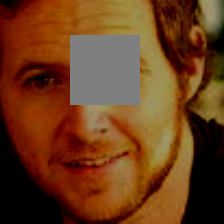

In [16]:
from google.colab.patches import cv2_imshow
print(image_f.size())
im = image_f.squeeze(0).detach().permute(1, 2, 0).numpy()
im = im[:,:,[2,1,0]]


cv2_imshow(im)


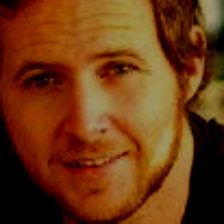

In [17]:
im = image.squeeze(0).detach().permute(1, 2, 0).numpy()
im = im[:,:,[2,1,0]]

cv2_imshow(im)

# Grad-Based Search

In [0]:
def helpersearching(model, grad, N, width, height, S, C):
      iterx = (N-width) // S
      itery = (N-height) // S
      losslist = []
      dict_ = {}
      for j in range(iterx):
          for k in range(itery):
            g = grad[:,:, S*j: S*j+height, S*k: S*k+width]
            loss = torch.sum(torch.sum(torch.sum(torch.mul(g,g),1),1),1)
            dict_[(j, k)] = loss
      dict_pos = sorted(dict_.items(),key=lambda item:item[1],reverse=True)[:C]
      return dict_pos
      

def gradient_based_search(model, image, label,rectangle, S, C):
  N = image.size()[2]
  print(rectangle.size())
  height = rectangle.size()[1]

  width = rectangle.size()[2]

  image = image.requires_grad_(True)
  output = model(image.to(device))
  loss = loss_function(output, label.to(device))
  loss.sum().backward()
  grad = image.grad.data

  max_val,_ = torch.max(torch.abs(grad.view(grad.shape[0], -1)),1)
  grad = grad/max_val

  dict_pos = helpersearching(model, grad, N, width, height, S, C)
  min = 1e4
  final_pos = None
  for pos, _ in dict_pos:
      rectangle = 127.5 * torch.ones((3,height,width))
      attack_image = image.clone()
      attack_image[:,:, S*pos[0]:S*pos[0]+height, S*pos[1]:S*pos[1]+width] = rectangle
      output = model(attack_image.to(device))
      index = output.argmax(dim=1)
      target = output[:,index].item()

      if target < min:
        min = target
        final_pos = pos
        image_final = attack_image

  
  return image_final,final_pos,grad


torch.Size([3, 70, 70])


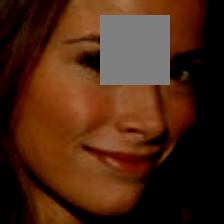

In [19]:

image, label = train_loader.dataset[3001]
label = torch.tensor([label],dtype=torch.long)
model.eval()
image_adv, pos,grad= gradient_based_search(model, image.unsqueeze(0), label, rectangle1, 5, 30)
pos_1, pos_2 = pos
im = image_adv.squeeze(0).detach().permute(1, 2, 0).numpy()

im = im[:,:,[2,1,0]]
cv2_imshow(im)

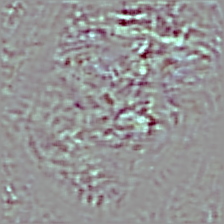

In [20]:
im1 = grad.squeeze(0).detach().permute(1, 2, 0).numpy()*255 + 150

im1 = im1[:,:,[2,1,0]]
cv2_imshow(im1)

# PGD

In [0]:
def PGD(image, label, rectangle, pos_1, pos_2, model, stride, iter, lr, initial):
  image = image.to(device)
  N = image.size()[2]
  H = rectangle.size()[1]
  W = rectangle.size()[2]
  mask = torch.zeros((N,N), requires_grad=True)
  mask[stride*pos_1:stride*pos_1 + H, stride*pos_2:stride*pos_2 + W] = 1.0
  mask = mask.to(device)

  # Initialize the input image before PGD
  if initial == 'random':
    patch = torch.rand_like(image, requires_grad=True).to(device)
    patch = patch*255
  elif initial == 'half':
    patch = torch.zeros_like(image, requires_grad=True).to(device) + 255/2
  
  image_adv = torch.rand_like(image, requires_grad=True).to(device)
  image_adv.data = image * (1-mask) + patch * mask
  im = image_adv.squeeze(0).cpu().detach().numpy()
  r = Image.fromarray(im[0]).convert('L')
  g = Image.fromarray(im[1]).convert('L')
  b = Image.fromarray(im[2]).convert('L')
  ima = Image.merge("RGB", (r, g, b))
  plt.imshow(ima)

  loss_function = nn.CrossEntropyLoss()

  # PGD interation
  for epoch in range(iter):
    output = model(image_adv)
    loss = loss_function(output, label.to(device))
    loss.backward()
    image_adv.data = image_adv.detach() + lr * image_adv.grad.detach().sign() * mask
    image_adv.data = (image_adv.detach()).clamp(0,255)
    image_adv.grad.zero_()
  label_final = model(image_adv)
  l = label_final.argmax(dim=1)

 
  return image_adv.detach(), l


In [0]:
image, label = train_loader.dataset[3001]
label = torch.tensor([label],dtype=torch.long)

image_adv, label_adv= PGD(image.unsqueeze(0), label, rectangle1, pos_1, pos_2, model, 5, 50, 8, 'half')

In [23]:
print(label,label_adv)

tensor([9]) tensor([5], device='cuda:0', grad_fn=<NotImplemented>)


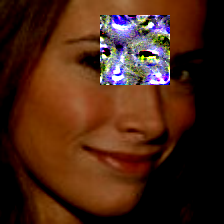

In [24]:

im = image_adv.squeeze(0).cpu().permute(1, 2, 0).numpy()
# r = Image.fromarray(im[0]).convert('L')
# g = Image.fromarray(im[1]).convert('L')
# b = Image.fromarray(im[2]).convert('L')
# ima = Image.merge("RGB", (r, g, b))
# plt.imshow(ima)
im = im[:,:,[2,1,0]]
cv2_imshow(im)

# Generate ROA Image

In [0]:

import os
 
def mkdir(path):
 
	folder = os.path.exists(path)
	if not folder:         
		os.makedirs(path)            
		print ("---  new folder...  ---")
		print ("---  OK  ---")
	else:



In [0]:
batch_size = 1
train_loader1 = data.DataLoader(train_data, batch_size=batch_size)
val_loader1 = data.DataLoader(val_data, batch_size=batch_size)
test_loader1 = data.DataLoader(test_data, batch_size=batch_size)

---  new folder...  ---
---  OK  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

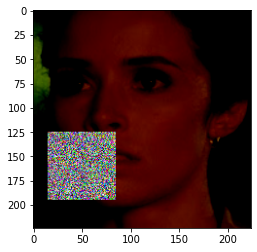

In [0]:
for i, batch_t in enumerate(train_loader1):
    
    images, labels = batch_t
    im, label = images[0,:,:,:], labels[0]
    dir = './ROA/%d' %label
    pos_1, pos_2, _ = ROA_Exhasted(im.unsqueeze(0), label, rectangle1, model)
    label = torch.tensor([label],dtype=torch.long)
    im_ROA, _ = PGD(im.unsqueeze(0), label, rectangle1, pos_1, pos_2, model, 5, 50, 4, 'random')
    im_ROA = im_ROA.squeeze(0).cpu().detach().numpy()
    mkdir(dir)
    r = Image.fromarray(im_ROA[0]).convert('L')
    g = Image.fromarray(im_ROA[1]).convert('L')
    b = Image.fromarray(im_ROA[2]).convert('L')
    ima = Image.merge("RGB", (r, g, b))
    ima.save(dir + '/%d.png'%i)
        # print(im_ROA.shape)
    # print(im_ROA.shape)
    # mkdir(dir)
    # im = Image.fromarray(im_ROA,mode=)
    # im.save(dir + '/%d.png'%((n+1)*i))



---  new folder...  ---
---  OK  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  new folder...  ---
---  OK  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  The

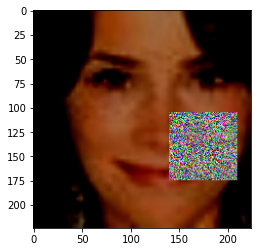

In [0]:
for i, batch_t in enumerate(val_loader1):
    
    images, labels = batch_t
    im, label = images[0,:,:,:], labels[0]
    dir = './val/%d' %label
    pos_1, pos_2, _ = ROA_Exhasted(im.unsqueeze(0), label, rectangle1, model)
    label = torch.tensor([label],dtype=torch.long)
    im_ROA, _ = PGD(im.unsqueeze(0), label, rectangle1, pos_1, pos_2, model, 5, 50, 4, 'random')
    im_ROA = im_ROA.squeeze(0).cpu().detach().numpy()
    mkdir(dir)
    r = Image.fromarray(im_ROA[0]).convert('L')
    g = Image.fromarray(im_ROA[1]).convert('L')
    b = Image.fromarray(im_ROA[2]).convert('L')
    ima = Image.merge("RGB", (r, g, b))
    ima.save(dir + '/%d.png'%i)

---  new folder...  ---
---  OK  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---

---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  new folder...  ---
---  OK  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---  There is this folder!  ---
---

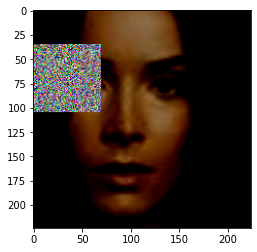

In [0]:
for i, batch_t in enumerate(test_loader1):
    
    images, labels = batch_t
    im, label = images[0,:,:,:], labels[0]
    dir = './test/%d' %label
    pos_1, pos_2, _ = ROA_Exhasted(im.unsqueeze(0), label, rectangle1, model)
    label = torch.tensor([label],dtype=torch.long)
    im_ROA, _ = PGD(im.unsqueeze(0), label, rectangle1, pos_1, pos_2, model, 5, 50, 4, 'random')
    im_ROA = im_ROA.squeeze(0).cpu().detach().numpy()
    mkdir(dir)
    r = Image.fromarray(im_ROA[0]).convert('L')
    g = Image.fromarray(im_ROA[1]).convert('L')
    b = Image.fromarray(im_ROA[2]).convert('L')
    ima = Image.merge("RGB", (r, g, b))
    ima.save(dir + '/%d.png'%i)

/bin/sh: 1: zip: not found
